In [ ]:
#%%

import numpy as np
import random
import time
import multiprocessing
from Digital_twin_simplified import DigitalTwin
from hyperparameters import hyperparameters
import os
import matplotlib.pyplot as plt
    
hp = hyperparameters()

def worker_simulate(args):
    """Helper function to run simulation in a worker process."""
    actions, dt_config = args # Unpack arguments
    # Create a DigitalTwin instance specific to this worker/task
    digital_twin = DigitalTwin() # Assuming DigitalTwin can take config dict

    # Reset state (important if DT instance is reused, but here we create anew)
    digital_twin.theta = 0.0
    digital_twin.theta_dot = 0.0
    digital_twin.x_pivot = 0.0
    digital_twin.steps = 0.0 # Assuming this is simulation steps count
    max_score = -np.inf

    # Use necessary parameters from dt_config
    simulation_steps = dt_config['simulation_steps']
    step_resolution = dt_config['step_resolution']

    for step in range(simulation_steps):
        if step % step_resolution == 0 and step // step_resolution < len(actions):
            action_index = actions[step // step_resolution]
             # Ensure action_map is accessible, maybe pass it in dt_config too
            direction, duration = dt_config['action_map'][action_index]
            digital_twin.perform_action(direction, duration)

        theta, theta_dot, x_pivot = digital_twin.step()
        max_score = max(max_score, -abs(theta - np.pi))
        if abs(digital_twin.x_pivot) > 0.135: # Use local digital_twin
             return -100 # Use a distinct failure value if needed
    return max_score

class InvertedPendulumGA:
    def __init__(self, population_size, num_actions, simulation_duration, action_resolution, simulation_delta_t, parent_pool_size=50, elite_size=15, print_output=True):
        self.action_resolution = simulation_duration / (num_actions + 1)
        # self.digital_twin = DigitalTwin()
        self.population_size = population_size
        self.parent_pool_size = parent_pool_size
        self.elite_size = elite_size
        self.num_actions = num_actions
        self.simulation_duration = simulation_duration
        self.action_resolution = action_resolution
        self.simulation_delta_t = simulation_delta_t
        self.simulation_steps = int(simulation_duration / simulation_delta_t)
        self.max_simulation_steps = int(simulation_duration / simulation_delta_t)
        self.num_steps = int(simulation_duration / action_resolution)
        self.step_resolution = int(action_resolution / simulation_delta_t)
        self. print_output = print_output
        temp_dt = DigitalTwin() # Create temporarily to get action_map
        self.dt_config = {
            'simulation_steps': self.simulation_steps,
            'step_resolution': self.step_resolution,
            'action_map': temp_dt.action_map, # Pass the action map
            # Add any other parameters DigitalTwin or simulate needs
        }
        del temp_dt # Don't keep the instance
        self.population = [self.create_individual() for _ in range(population_size)]
        # fitness_scores = self.evaluate_population()
        # print(fitness_scores, "at start")

    def create_individual(self):

        action_to_distance = {            
            8: 0.10395276894801612,     # ;
            7: 0.046038796770503654,    # l
            6: 0.014913007558438687,    # k
            5: 0.00235862223393408,     # j
            4: -0.10395276894801612,    # a 
            3: -0.046038796770503654,   # s
            2: -0.014913007558438687,   # d
            1: -0.00235862223393408,    # f
            0: 0.0
        }
        actions = np.zeros(self.num_steps, dtype=int)
        action_map = action_to_distance #self.dt_config['action_map']
        net_movement = 0
        i=0
        while i < self.num_steps:
            # Your logic for choosing action
            if abs(net_movement) < hp.TRACK_LENGTH:
               action = np.random.randint(1, self.num_actions) # Assuming action indices are 1 to num_actions-1
            elif net_movement >= hp.TRACK_LENGTH:
               action = np.random.choice([1, 2, 3, 4]) # Example action indices
            else: # net_movement <= -100
               action = np.random.choice([5, 6, 7, 8]) # Example action indices

            actions[i] = action
            if action in action_map:
                # Update net_movement based on the action chosen
                # Assuming action_map returns a distance or change in position
                net_movement += action_map[action]
            i += 1
            if abs(net_movement) > hp.TRACK_LENGTH:
                i -=1

        return actions

    def evaluate_population(self, pool, steps):
        
        self.dt_config['simulation_steps'] = self.max_simulation_steps #int(steps)
        args_list = [(individual, self.dt_config) for individual in self.population]
        fitness_scores = pool.map(worker_simulate, args_list)
        return fitness_scores

    def select_parents(self, fitness_scores):
        # Ensure fitness_scores and self.population align correctly
        valid_indices = [i for i, score in enumerate(fitness_scores) if score != -100] # Example: ignore failures
        valid_scores = [fitness_scores[i] for i in valid_indices]
        valid_population = [self.population[i] for i in valid_indices]

        if not valid_scores: # Handle case where all simulations failed
            if self.print_output:
                print("Warning: All individuals failed simulation.")
            # Fallback: maybe select randomly or return empty list?
            # For now, just selecting from the original population randomly might be a fallback
            indices = np.random.choice(len(self.population), self.parent_pool_size, replace=False)
            return [self.population[i] for i in indices]


        # Select from valid individuals
        pool_size = min(self.parent_pool_size, len(valid_scores))
        # Argsort sorts ascending, so smallest scores (best fitness) are first
        sorted_indices_in_valid = np.argsort(valid_scores)
        # Select the indices corresponding to the best scores within the valid subset
        top_performers_original_indices = [valid_indices[i] for i in sorted_indices_in_valid[:pool_size]]

        # Return the actual individuals from the original population
        return [self.population[i] for i in top_performers_original_indices]

    def crossover(self, parent1, parent2):
        crossover_points = sorted(random.sample(range(1, self.num_steps), 2))
        offspring = np.concatenate([
            parent1[:crossover_points[0]],
            parent2[crossover_points[0]:crossover_points[1]],
            parent1[crossover_points[1]:]
        ])
        return offspring

    def mutate(self, individual, mutation_rate=0.3):
        mask = np.random.rand(self.num_steps) < mutation_rate
         # Ensure mutation generates valid action indices (e.g., 1 to num_actions-1)
        num_mutations = np.sum(mask)
        if num_mutations > 0:
             individual[mask] = np.random.randint(1, self.num_actions, size=num_mutations)
        return individual

    def run_generation(self, pool, num_elites=15, steps=500, fitness_scores=None):
        # fitness_scores = self.evaluate_population(pool, steps) # Pass pool

        # --- Elitism: Select best individuals directly ---
        # Ensure we handle potential failures (-100) if using that flag
        valid_fitness_indices = [(i, score) for i, score in enumerate(fitness_scores) if score != -100]

        if not valid_fitness_indices:
            if self.print_output:
                print("Warning: All individuals failed simulation.")
            # Handle this case: maybe generate a new random population?
            # For now, let's skip elitism and selection if all failed.
            parents_pool = [self.create_individual() for _ in range(self.population_size)] # Fallback
            elites = []
        else:
            # Sort valid individuals by score (descending, higher is better)
            valid_fitness_indices.sort(key=lambda x: x[1], reverse=True)
            # Get the indices of the best individuals from the original population list
            elite_indices = [idx for idx, score in valid_fitness_indices[:num_elites]]
            elites = [self.population[i] for i in elite_indices]

            # --- Parent Selection ---
            # Use the selection method on all fitness scores (it should handle failures)
            parents_pool = self.select_parents(fitness_scores)
            if not parents_pool: # Handle empty parent pool if select_parents has issues
                if self.print_output:
                    print("Warning: Parent pool is empty. Using random individuals.")
                parents_pool = [self.create_individual() for _ in range(self.population_size)]


        # --- Create New Population ---
        new_population = list(elites) # Start with elites
        np.random.shuffle(parents_pool)

        while len(new_population) < self.population_size:
            # Ensure there are enough parents for crossover
            if len(parents_pool) < 2:
                # Not enough parents, fill remainder with mutated elites or randoms
                if self.print_output:
                    print("Warning: Not enough parents for crossover. Filling population.")
                fill_count = self.population_size - len(new_population)
                for _ in range(fill_count):
                    if elites: # Mutate an elite if possible
                         new_population.append(self.mutate(random.choice(elites).copy()))
                    else: # Otherwise create random
                         new_population.append(self.create_individual())
                break # Exit the while loop

            # Select two parents
            parent1 = parents_pool[0]
            parent2 = parents_pool[1]
            parents_pool = parents_pool[2:] # Remove used parents (simple strategy)

            # Crossover and Mutate
            offspring1 = self.crossover(parent1, parent2)
            offspring2 = self.crossover(parent2, parent1)
            new_population.append(self.mutate(offspring1))
            if len(new_population) < self.population_size:
                 new_population.append(self.mutate(offspring2))

             # Replenish parent pool if it gets low and we still need individuals
            if len(parents_pool) < 2 and len(new_population) < self.population_size:
                if self.print_output:
                    print("Replenishing parent pool for crossover.")
                 # Option: Re-use selected parents, or re-select based on scores
                parents_pool.extend(self.select_parents(fitness_scores)) # Re-select (might be inefficient)
                np.random.shuffle(parents_pool)


        self.population = new_population[:self.population_size]


    def optimize(self, num_generations, fitness_threshold):
        # Create the pool *outside* the loop
        # Determine number of processes (adjust as needed)
        num_processes = max(1, os.cpu_count() - 1) if os.cpu_count() else 1
        if self.print_output:
            print(f"Using {num_processes} worker processes.")

        min_value = 500
        max_value = self.max_simulation_steps
        delta = max_value - min_value

        with multiprocessing.Pool(processes=num_processes) as pool:
            best_overall_fitness = -np.inf # Assuming lower is better (e.g., min angle)
            best_overall_solution = None
            fitness_history = []
            current_fitness_scores = self.evaluate_population(pool, 500)
            for i in range(num_generations):
                proposed_simulation_steps = (delta/num_generations) * (i) + min_value
                self.run_generation(pool, steps=proposed_simulation_steps, fitness_scores=current_fitness_scores) # Pass the existing pool                

                # Evaluate the new population to find the best of this generation
                current_fitness_scores = self.evaluate_population(pool, proposed_simulation_steps)
                valid_scores = [s for s in current_fitness_scores if s != -100]

                if not valid_scores:
                     if self.print_output:
                          print(f"Generation {i}: All individuals failed.")
                     current_best_fitness = -np.inf  # Initialize to negative infinity
                     best_gen_solution = None
                else:
                     # Find best fitness in this generation (assuming lower is better)
                     current_best_fitness = max(valid_scores)
                     best_gen_index = current_fitness_scores.index(current_best_fitness)
                     best_gen_solution = self.population[best_gen_index]

                # print(f"Generation: {i}, Best Fitness: {current_best_fitness}, proposed_steps: {proposed_simulation_steps}")

                # Update overall best if this generation is better
                if current_best_fitness > best_overall_fitness:
                    best_overall_fitness = current_best_fitness
                    best_overall_solution = best_gen_solution
                    if self.print_output:
                        print(f"Generation: {i}, Best Fitness: {current_best_fitness}")
                    fitness_history.append([current_best_fitness, i])
            if self.print_output:
                print(f"Optimization finished. Best fitness after {num_generations} generations is {best_overall_fitness}.")
            return best_overall_solution, current_best_fitness, fitness_history # Return the best solution found across all generations

    # inject_elite needs adaptation if evaluate_population now requires a pool
    def inject_elite(self, elite, pool): # Requires pool
         self.population[0] = np.array(elite)
         self.evaluate_population(pool) # Need to evaluate to update scores if needed by selection

Optimization took 33.82 seconds.
Best Solution: 6, 1, 6, 2, 1, 3, 6, 2, 6, 2, 8, 3, 8, 4, 8, 4, 8, 4, 7, 6


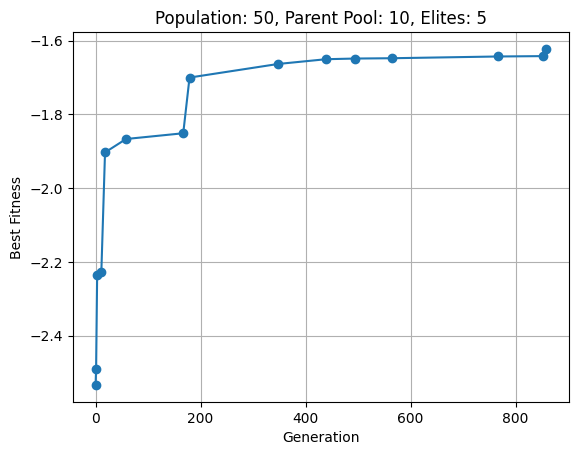

Optimization took 33.90 seconds.
Best Solution: 6, 4, 8, 5, 6, 1, 5, 4, 8, 3, 8, 4, 8, 4, 8, 4, 6, 5, 8, 6


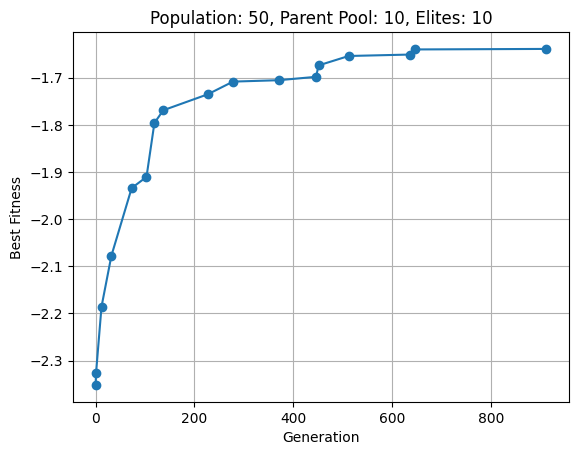

Optimization took 35.08 seconds.
Best Solution: 5, 5, 6, 6, 3, 6, 2, 6, 3, 7, 3, 5, 3, 8, 4, 8, 4, 8, 4, 2


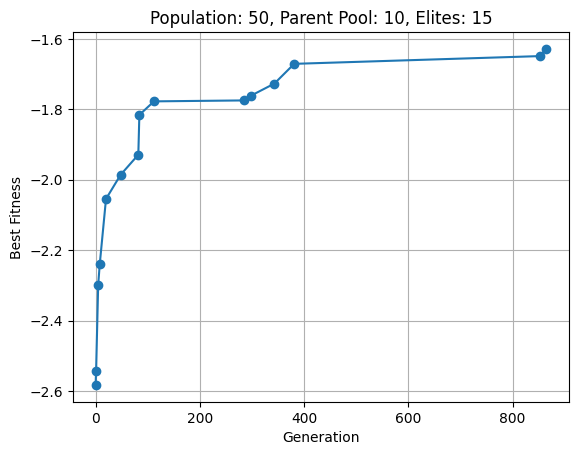

Optimization took 36.22 seconds.
Best Solution: 7, 2, 7, 2, 6, 2, 6, 1, 7, 3, 7, 4, 8, 4, 8, 4, 5, 6, 2, 1


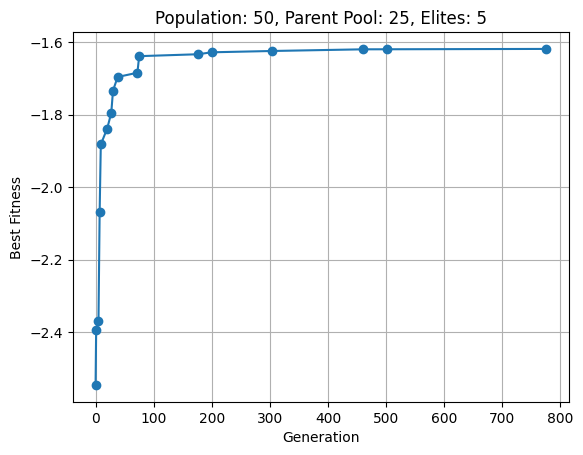

Optimization took 36.42 seconds.
Best Solution: 7, 4, 7, 2, 7, 3, 8, 3, 7, 4, 8, 4, 8, 4, 8, 5, 4, 8, 3, 1


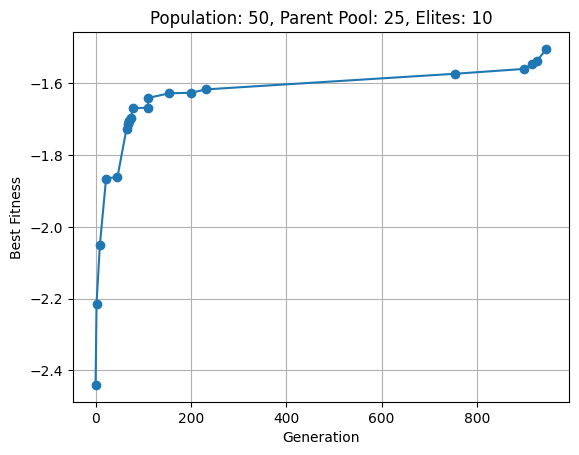

Optimization took 34.45 seconds.
Best Solution: 3, 8, 3, 5, 3, 8, 4, 7, 4, 8, 4, 8, 4, 8, 5, 3, 7, 4, 8, 4


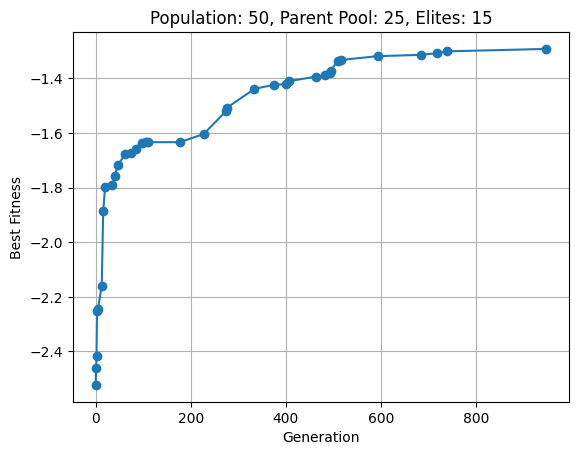

Optimization took 39.70 seconds.
Best Solution: 7, 1, 5, 2, 5, 1, 6, 1, 6, 2, 6, 1, 7, 4, 8, 4, 8, 4, 8, 4


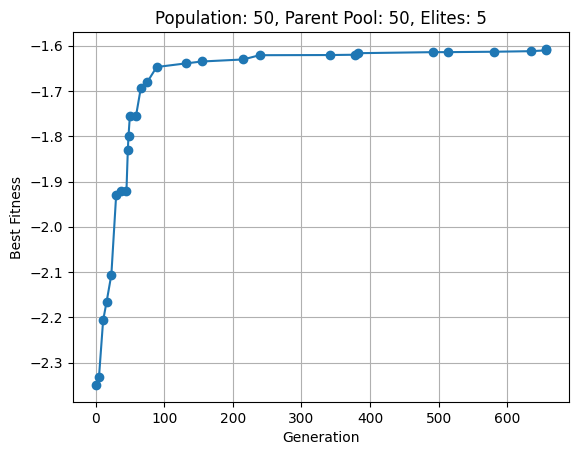

Optimization took 35.32 seconds.
Best Solution: 8, 3, 7, 4, 7, 4, 8, 3, 8, 4, 8, 4, 8, 5, 4, 8, 4, 8, 4, 8


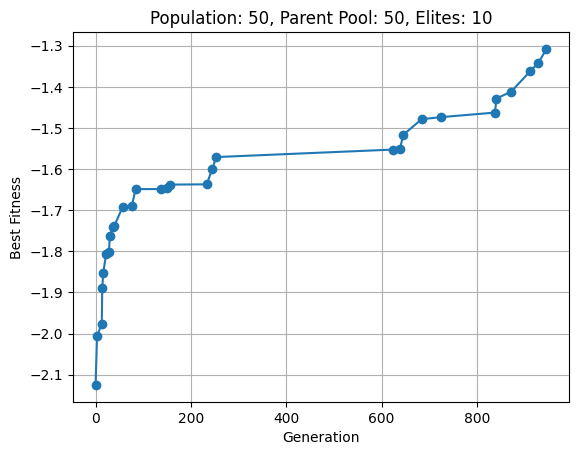

Optimization took 39.33 seconds.
Best Solution: 3, 7, 2, 6, 2, 5, 1, 1, 3, 6, 3, 6, 2, 8, 4, 8, 4, 8, 4, 1


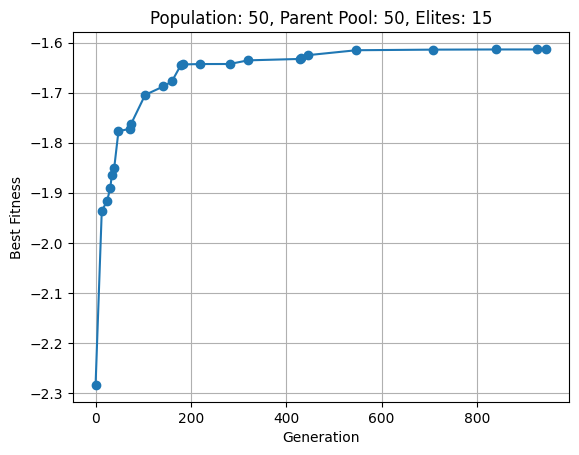

Optimization took 68.30 seconds.
Best Solution: 3, 6, 8, 1, 4, 7, 2, 7, 1, 6, 5, 7, 4, 8, 3, 5, 2, 7, 1, 5


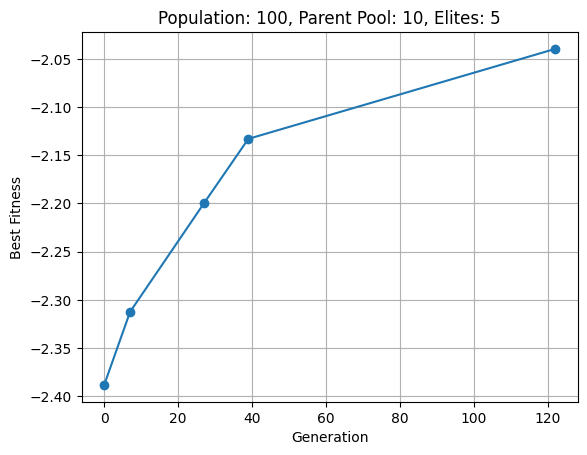

Optimization took 67.61 seconds.
Best Solution: 4, 5, 2, 5, 2, 6, 1, 8, 1, 5, 2, 7, 3, 7, 1, 7, 1, 1, 2, 2


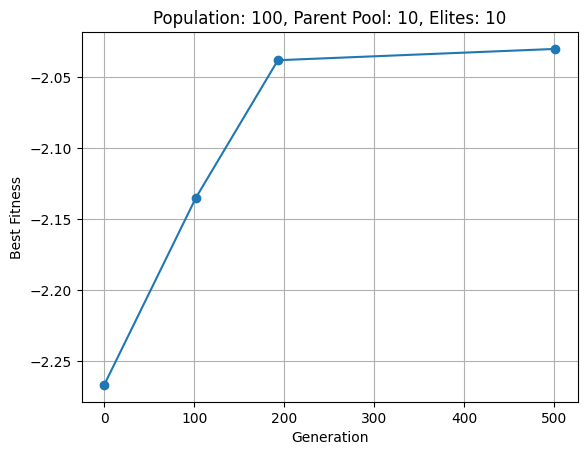

Optimization took 67.50 seconds.
Best Solution: 4, 7, 8, 3, 8, 6, 6, 4, 8, 2, 5, 4, 6, 1, 8, 3, 7, 3, 4, 8


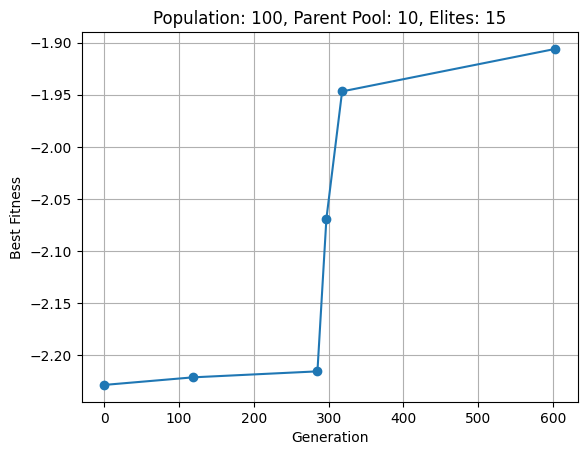

Optimization took 63.45 seconds.
Best Solution: 2, 7, 2, 6, 1, 7, 2, 6, 2, 6, 3, 8, 4, 8, 4, 8, 4, 6, 4, 7


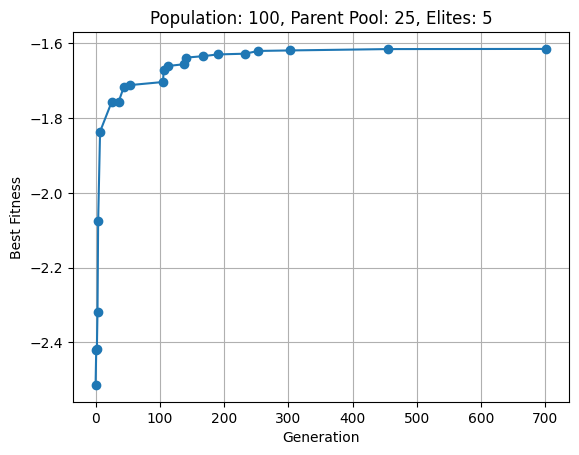

Optimization took 60.14 seconds.
Best Solution: 7, 4, 7, 3, 8, 3, 8, 4, 7, 4, 8, 4, 8, 4, 1, 6, 2, 8, 4, 1


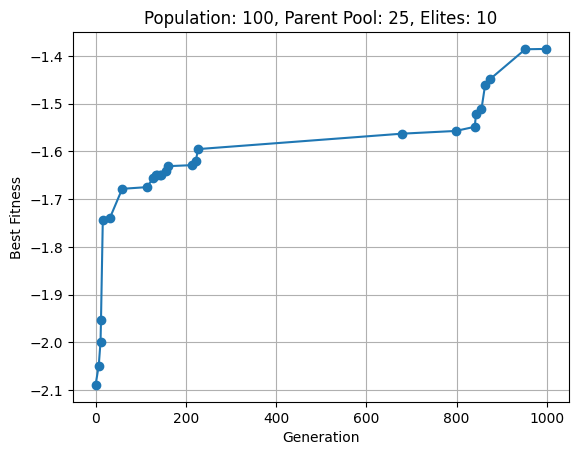

Optimization took 58.18 seconds.
Best Solution: 4, 8, 3, 8, 3, 6, 4, 7, 3, 8, 4, 8, 4, 8, 4, 3, 8, 4, 8, 4


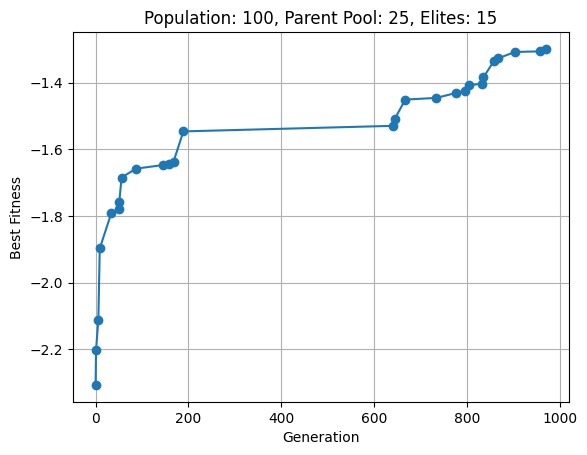

Optimization took 65.70 seconds.
Best Solution: 7, 2, 6, 2, 6, 2, 5, 2, 6, 2, 6, 2, 8, 4, 8, 4, 8, 4, 7, 1


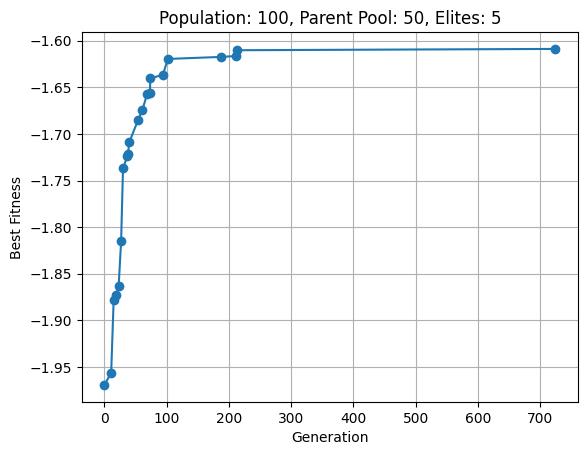

Optimization took 65.53 seconds.
Best Solution: 6, 3, 6, 2, 6, 1, 5, 1, 6, 2, 7, 3, 8, 4, 8, 4, 8, 4, 5, 8


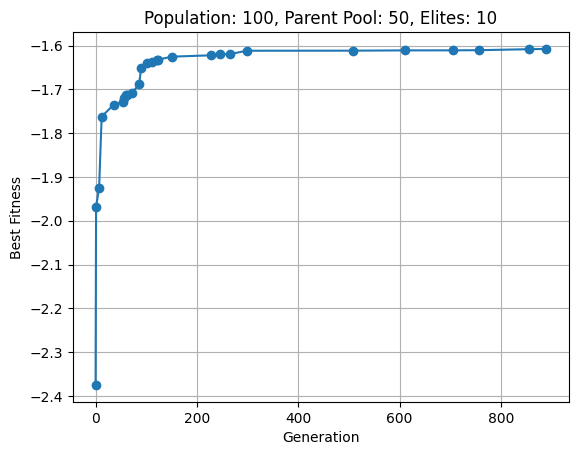

Optimization took 57.74 seconds.
Best Solution: 7, 4, 8, 3, 7, 4, 8, 4, 8, 4, 8, 4, 2, 7, 4, 8, 3, 8, 4, 5


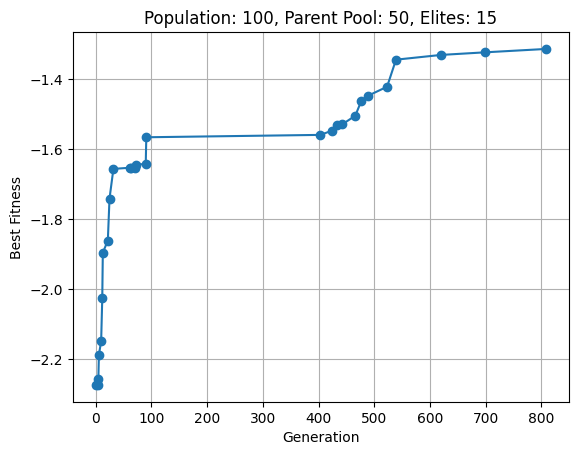

Optimization took 130.33 seconds.
Best Solution: 7, 2, 5, 4, 7, 2, 8, 1, 1, 1, 5, 3, 8, 4, 5, 4, 2, 5, 6, 1


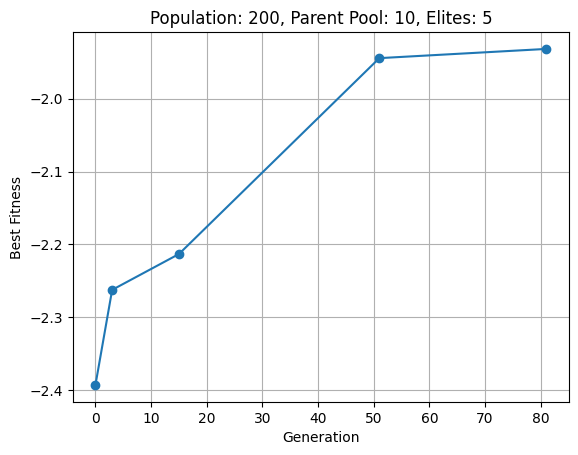

Optimization took 127.67 seconds.
Best Solution: 4, 8, 7, 7, 3, 7, 5, 6, 1, 5, 4, 7, 4, 8, 5, 2, 4, 8, 2, 1


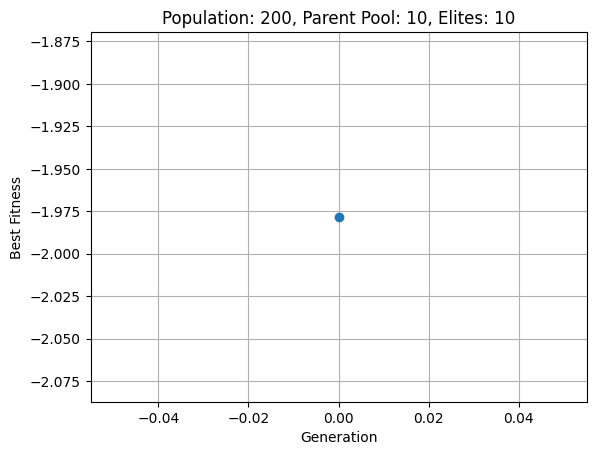

Optimization took 129.07 seconds.
Best Solution: 8, 4, 6, 4, 6, 2, 5, 2, 8, 2, 6, 5, 7, 2, 6, 2, 1, 7, 5, 5


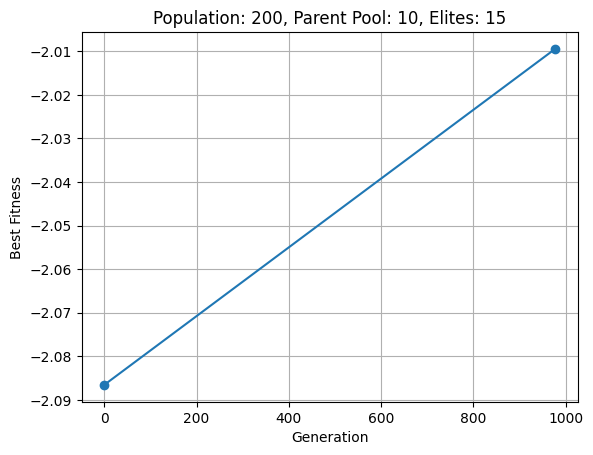

Optimization took 124.66 seconds.
Best Solution: 3, 8, 6, 7, 5, 2, 4, 6, 3, 1, 1, 8, 3, 5, 3, 6, 4, 8, 4, 5


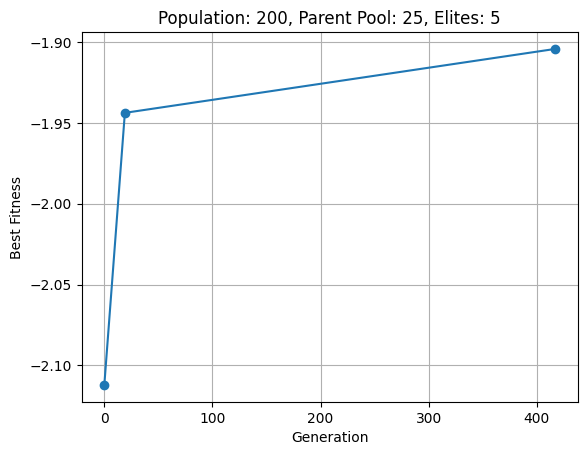

Optimization took 126.23 seconds.
Best Solution: 8, 1, 1, 4, 5, 7, 6, 4, 6, 2, 8, 5, 6, 1, 7, 4, 8, 2, 6, 3


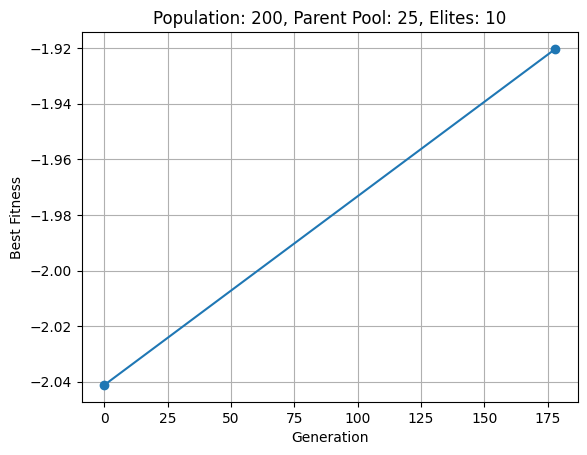

Optimization took 126.35 seconds.
Best Solution: 5, 1, 5, 8, 4, 7, 2, 6, 1, 5, 2, 5, 3, 6, 3, 6, 3, 6, 1, 5


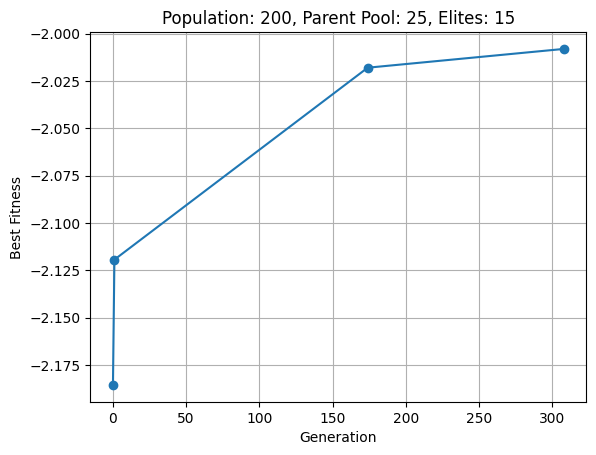

Optimization took 116.51 seconds.
Best Solution: 2, 6, 2, 5, 1, 6, 1, 6, 2, 6, 2, 6, 4, 8, 4, 8, 4, 8, 4, 2


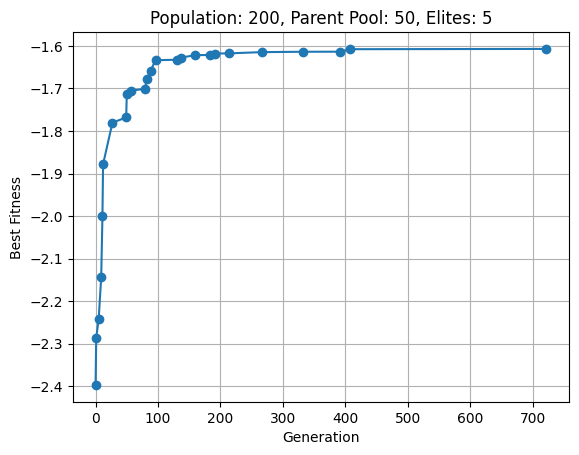

Optimization took 118.63 seconds.
Best Solution: 2, 6, 2, 7, 1, 6, 1, 6, 1, 6, 2, 6, 3, 8, 4, 8, 4, 8, 4, 7


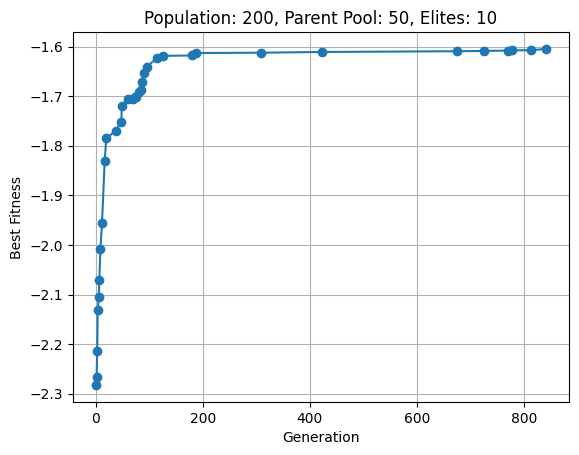

Optimization took 101.55 seconds.
Best Solution: 4, 7, 3, 7, 2, 7, 3, 8, 4, 8, 4, 8, 4, 8, 7, 4, 8, 4, 8, 4


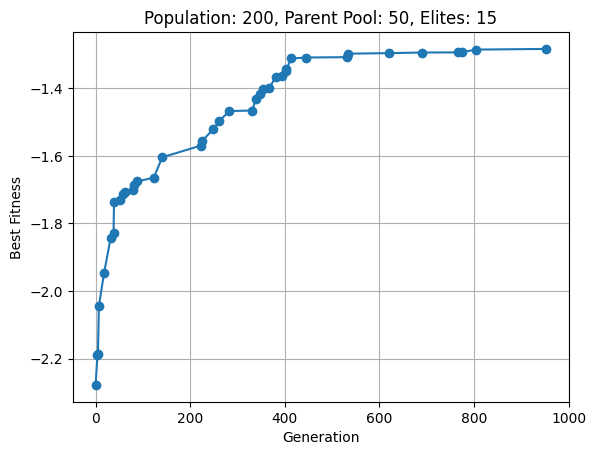

In [ ]:
#%%

def run_simulation(num_generation, population_size, parent_pool, elites, simulation_duration=10, action_resolution=0.5, print_output=True):
    ga = InvertedPendulumGA(population_size=population_size,
                            num_actions=9, # Check if this matches action_map size/logic
                            simulation_duration=simulation_duration,
                            action_resolution=action_resolution,
                            simulation_delta_t=hp.DELTA_T,
                            parent_pool_size=parent_pool,
                            elite_size=elites,
                            print_output=print_output)

    start_time = time.time()
    # Threshold likely needs adjustment based on fitness definition
    # If minimizing max angle, threshold should be small (e.g., 0.05 radians)
    best_solution, best_fitness, fitness_history = ga.optimize(num_generations=num_generation, fitness_threshold=np.pi) # <--- INCREASED Generations, ADJUSTED Threshold
    end_time = time.time()

    actions = list(best_solution)  # Ensure it's a list, not a numpy array
    actions.append(best_fitness)  # Append the best fitness score to the solution

    folder_path = "./best_actions"
    file_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
    np.save(f"{folder_path}/best_actions_{file_count}.npy", best_solution)

    print(f"Optimization took {end_time - start_time:.2f} seconds.")

    if best_solution is not None:
         print("Best Solution:", ", ".join(map(str, best_solution)))
    else:
         print("No solution met the criteria or all simulations failed.")

    return best_solution, best_fitness, fitness_history

if __name__ == '__main__':
    population_range = [50, 100, 200]
    parent_pool_range = [10, 25, 50]
    elite_range = [5, 10, 15]
    # population_range = [50]
    # parent_pool_range = [10]
    # elite_range = [5]
    for population_size in population_range:
        for parent_pool in parent_pool_range:
            for elites in elite_range:
                # print(f"Running simulation with Population: {population_size}, Parent Pool: {parent_pool}, Elites: {elites}")
                best_solution, best_fitness, fitness_history = run_simulation(num_generation=1000,
                    population_size=population_size,
                    parent_pool=parent_pool,
                    elites=elites,
                    simulation_duration=10,
                    action_resolution=0.5,
                    print_output=False)
    
                # Plotting the fitness history
                x_values = [entry[1] for entry in fitness_history]
                y_values = [entry[0] for entry in fitness_history]

                plt.plot(x_values, y_values, marker='o')
                plt.xlabel('Generation')
                plt.ylabel('Best Fitness')
                plt.title(f'Population: {population_size}, Parent Pool: {parent_pool}, Elites: {elites}')
                plt.grid(True)
                plt.show()